In [1]:
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image
import time
import numpy as np
import scipy.io
import cv2
try:
  import mediapipe as mp
except:
  !pip install mediapipe
import mediapipe as mp
from collections import Counter
from skimage.metrics import structural_similarity as ssim
from collections import defaultdict

In [2]:
frames_dir = "../penn_action_raw/Penn_Action/frames"
labels_dir = "../penn_action_raw/Penn_Action/labels"

In [3]:
def print_unique_frame_counts(frames_dir):
    """
    Prints the unique number of frames across all videos,
    and how many videos have each count.
    """
    frame_counts = []

    for video_id in sorted(os.listdir(frames_dir)):
        video_path = os.path.join(frames_dir, video_id)
        if os.path.isdir(video_path):
            frame_files = [
                f for f in os.listdir(video_path)
                if os.path.isfile(os.path.join(video_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            frame_counts.append(len(frame_files))

    count_distribution = Counter(frame_counts)

    print(f"{'Frame Count':<15} {'# of Videos':<15}")
    print("-" * 30)
    for count, num_videos in sorted(count_distribution.items()):
        print(f"{count:<15} {num_videos:<15}")


In [5]:
def get_video_ids_by_frame_count(frames_dir):
    """
    Returns a dictionary mapping frame counts to the list of video IDs
    that have that exact number of frames.
    """
    frame_count_to_ids = defaultdict(list)

    for video_id in sorted(os.listdir(frames_dir)):
        video_path = os.path.join(frames_dir, video_id)
        if os.path.isdir(video_path):
            frame_files = [
                f for f in os.listdir(video_path)
                if os.path.isfile(os.path.join(video_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            frame_count = len(frame_files)
            frame_count_to_ids[frame_count].append(video_id)

    return dict(frame_count_to_ids)


In [7]:
def is_similar(img1, img2, threshold):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    score, _ = ssim(gray1, gray2, full=True)
    return score > threshold
    
def show_video_with_pose(video_id, frames_dir, labels_dir, delay=0, optimized=True, threshold=0.89):
    """
    Preload and display a Penn Action video smoothly,
    overlaying human poses from annotation files.
    If optimized=True, skips visually similar consecutive frames.
    """
    video_path = os.path.join(frames_dir, video_id)
    label_path = os.path.join(labels_dir, f"{video_id}.mat")

    # Load annotation
    mat = scipy.io.loadmat(label_path)
    x = mat['x']     # Shape (nframes, 13)
    y = mat['y']
    visibility = mat['visibility']

    # Load frames
    frame_files = sorted(
        [f for f in os.listdir(video_path)
         if os.path.isfile(os.path.join(video_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    )
    frames = [np.array(Image.open(os.path.join(video_path, f))) for f in frame_files]

    # Display setup
    fig, ax = plt.subplots()
    img_obj = ax.imshow(frames[0])
    plt.axis('off')
    scat = ax.scatter([], [], s=20, c='red')  # Initialize scatter for keypoints

    prev_frame = None
    n_frames_shown = 0

    for frame_idx, frame in enumerate(frames):
        # Optimization: Skip similar frames
        if optimized and prev_frame is not None and is_similar(prev_frame, frame, threshold):
            continue

        prev_frame = frame  # Update previous frame

        # Update image
        img_obj.set_data(frame)

        # Extract keypoints
        keypoints_x = x[frame_idx, :]
        keypoints_y = y[frame_idx, :]
        visible = visibility[frame_idx, :].astype(bool)

        # Only plot visible keypoints
        keypoints = np.array([[keypoints_x[i], keypoints_y[i]] for i in range(13) if visible[i]])
        if keypoints.size > 0:
            scat.set_offsets(keypoints)
        else:
            scat.set_offsets(np.empty((0, 2)))  # No visible joints

        display(fig)
        clear_output(wait=True)
        time.sleep(delay)
        n_frames_shown += 1

    print(f"Displayed {n_frames_shown} frames with pose overlay (out of {len(frames)} total).")

Displayed 19 frames with pose overlay (out of 151 total).


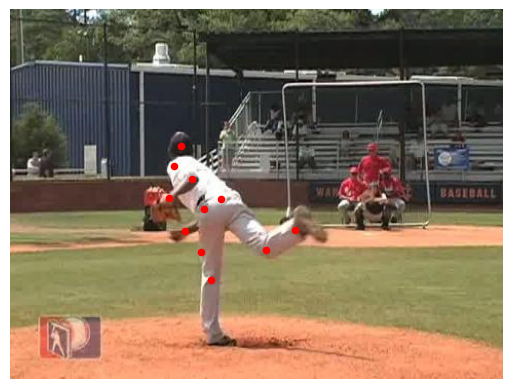

In [13]:
show_video_with_pose('0001', frames_dir, labels_dir, optimized=True)

In [9]:
def find_top_extreme_videos(frames_dir, top_k=10):
    video_lengths = {}

    for video_id in sorted(os.listdir(frames_dir)):
        video_path = os.path.join(frames_dir, video_id)

        if not os.path.isdir(video_path):
            continue

        frame_files = [
            f for f in os.listdir(video_path)
            if os.path.isfile(os.path.join(video_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        video_lengths[video_id] = len(frame_files)

    # Sort by length
    sorted_videos = sorted(video_lengths.items(), key=lambda x: x[1])
    
    shortest_videos = sorted_videos[:top_k]
    longest_videos = sorted_videos[-top_k:]

    return shortest_videos, longest_videos

In [10]:
# longest, long_len, shortest, short_len = find_extreme_videos(frames_dir)
# print(f"Longest video: {longest} ({long_len} frames)")
# print(f"Shortest video: {shortest} ({short_len} frames)")
# --> OUT : 
# Longest video: 0758 (663 frames)
# Shortest video: 1114 (18 frames)

In [11]:
#shortest, longest = find_top_extreme_videos(frames_dir)
#
#print("Top 10 Shortest Videos:")
#for vid, length in shortest:
#    print(f"{vid}: {length} frames")
#
#print("\nTop 10 Longest Videos:")
#for vid, length in reversed(longest):
#    print(f"{vid}: {length} frames")
#Top 10 Shortest Videos:
#1114: 18 frames
#1117: 18 frames
#1959: 18 frames
#1269: 19 frames
#1925: 19 frames
#1123: 21 frames
#1929: 21 frames
#1949: 21 frames
#1053: 22 frames
#1088: 22 frames
#
#Top 10 Longest Videos:
#0758: 663 frames
#0748: 657 frames
#0623: 564 frames
#0731: 491 frames
#0755: 422 frames
#0736: 416 frames
#0750: 408 frames
#0723: 403 frames
#0761: 402 frames
#0746: 395 frames

# Data Filtering:
- Should Remove strumming_guitar actions
- Any other videos from the previous set is considered to be valid and the optimized should only be done when the number of frames are higher than 35.

In [9]:
from collections import Counter
from PIL import Image

def print_unique_frame_dimensions(frames_dir):
    """
    Prints the unique frame dimensions (H, W) across all videos,
    and how many videos have each.
    """
    dimensions = []

    for video_id in sorted(os.listdir(frames_dir)):
        video_path = os.path.join(frames_dir, video_id)
        if os.path.isdir(video_path):
            frame_files = sorted([
                f for f in os.listdir(video_path)
                if os.path.isfile(os.path.join(video_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            if frame_files:
                frame_path = os.path.join(video_path, frame_files[0])
                with Image.open(frame_path) as img:
                    h, w = img.size[1], img.size[0]  # PIL returns (W, H)
                    dimensions.append((h, w))

    dimension_counts = Counter(dimensions)

    print(f"{'Frame Dimension (H, W)':<25} {'# of Videos':<15}")
    print("-" * 45)
    for dim, count in sorted(dimension_counts.items()):
        print(f"{str(dim):<25} {count:<15}")


In [12]:
print_unique_frame_dimensions(frames_dir)

Frame Dimension (H, W)    # of Videos    
---------------------------------------------
(204, 480)                3              
(234, 480)                1              
(258, 480)                1              
(264, 480)                11             
(266, 480)                2              
(267, 480)                3              
(269, 480)                1              
(270, 480)                1271           
(271, 480)                37             
(272, 480)                35             
(275, 480)                1              
(276, 480)                4              
(288, 480)                3              
(294, 480)                1              
(318, 480)                47             
(320, 480)                48             
(324, 480)                6              
(326, 480)                1              
(328, 480)                1              
(336, 480)                1              
(342, 480)                1              
(347, 480)                1   